# Berater Environment v12

## Changes from v12
* Work In Progress: 
  * alternative model trained using A2C
     * does not train, yet
     * need to explore parameters to learn
     
## next steps
* port to A2C in TF 2.0: https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/rl/actor-critic-agent-with-tensorflow2.ipynb#scrollTo=6J4MJARQUTKt

## Installation (required for colab)

In [0]:
!pip install git+https://github.com/openai/baselines >/dev/null
!pip install gym >/dev/null

## Environment

In [0]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = destination == 'S' and self.all_customers_visited()

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/2)
#       number_per_consultant = int(number_of_customers/1.5)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [0]:
env = BeraterEnv()
print(env.reset())
print(env.customer_reward)

[    0.  -300.   900.  -200. -1000.     0.     0.  1000.     0.  1000.
     0.     0.  1000.     0.     0.  1000.  1000.  1000.     0.]
{'S': 0, 'A': 0, 'B': 1000, 'C': 0, 'D': 1000, 'E': 0, 'F': 0, 'G': 1000, 'H': 0, 'K': 0, 'L': 1000, 'M': 1000, 'N': 1000, 'O': 0}


# Try out Environment

In [0]:
BeraterEnv.showStep = True
BeraterEnv.showDone = True

env = BeraterEnv()
print(env)
observation = env.reset()
print(observation)

for t in range(1000):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    if done:
        print("Episode finished after {} timesteps".format(t+1))
        break
env.close()
print(observation)

<BeraterEnv instance>
[    0.   700.   900.   800. -1000.     0.  1000.  1000.  1000.     0.
     0.     0.     0.     0.     0.  1000.  1000.  1000.     0.]
Episode:    0   Step:    1  S --0-> A R= 0.12 totalR= 0.12 cost= 300 customerR=1000 optimum=6000
Episode:    0   Step:    2  A --3-> D R=-0.02 totalR= 0.10 cost= 100 customerR=   0 optimum=6000
Episode:    0   Step:    3  D --1-> F R=-0.01 totalR= 0.09 cost=  50 customerR=   0 optimum=6000
Episode:    0   Step:    4  F --0-> D R=-0.01 totalR= 0.08 cost=  50 customerR=   0 optimum=6000
Episode:    0   Step:    5  D --3-> D R=-0.17 totalR=-0.08 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    6  D --3-> D R=-0.17 totalR=-0.25 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    7  D --3-> D R=-0.17 totalR=-0.42 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    8  D --3-> D R=-0.17 totalR=-0.58 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    9  D --1-> F R=-0.01 totalR=-0.59 cost=  

## Baseline

In [0]:
from copy import deepcopy
import json

class Baseline():

  def __init__(self, env, verbose=1):
    self.env = env
    self.verbose = verbose
    self.reset()

  def reset(self):
    self.map = self.env.map
    self.rewards = self.env.customer_reward.copy()
    
  def as_string(self, state):
    # reward/cost does not hurt, but is useless, path obsucres same state
    new_state = {
        'rewards': state['rewards'],
        'position': state['position']
    }
    return json.dumps(new_state, sort_keys=True)
  
  def is_goal(self, state):
    if state['position'] != 'S': return False
    for reward in state['rewards'].values():
      if reward != 0: return False
    return True
    

  def expand(self, state):
    states = []
    for position, cost in self.map[state['position']]:
      new_state = deepcopy(state)
      new_state['position'] = position
      new_state['rewards'][position] = 0
      reward = state['rewards'][position]
      new_state['reward'] += reward
      new_state['cost'] += cost
      new_state['path'].append(position)
      states.append(new_state)
    return states

  def search(self, root, max_depth = 25):
      closed = set()
      open = [root]

      while open:
          state = open.pop(0)
          if self.as_string(state) in closed: continue  

          closed.add(self.as_string(state))

          depth = len(state['path'])
          if depth > max_depth:
            if self.verbose > 0:
              print("Visited:", len(closed))
              print("Reached max depth, without reaching goal")
            return None

          if self.is_goal(state):
            scaled_reward = (state['reward'] - state['cost']) / 6000
            state['scaled_reward'] = scaled_reward
            if self.verbose > 0:
              print("Scaled reward:", scaled_reward)            
              print("Perfect path", state['path'])
            return state

          expanded = self.expand(state)
          open += expanded
          # make this best first
          open.sort(key=lambda state: state['cost'])
        
  def find_optimum(self):
    initial_state = {
        'rewards': self.rewards.copy(),
        'position': 'S',
        'reward': 0,
        'cost': 0,
        'path': ['S']
    }
    return self.search(initial_state)
  
  def benchmark(self, model, sample_runs=100):
    self.verbose = 0
    BeraterEnv.showStep = False
    BeraterEnv.showDone = False

    perfect_rewards = []
    model_rewards = []
    for run in range(sample_runs):
      observation = self.env.reset()
      self.reset()
      
      optimum_state = self.find_optimum()
      perfect_rewards.append(optimum_state['scaled_reward'])
      
      state = np.zeros((1, 2*128))
      dones = np.zeros((1))

      for t in range(1000):
        actions, _, state, _ = model.step(observation, S=state, M=dones)
        observation, reward, done, info = self.env.step(actions[0])
        if done:
          break
      model_rewards.append(env.totalReward)
    return perfect_rewards, model_rewards
  
  def score(self, model, sample_runs=100):
    perfect_rewards, model_rewards = self.benchmark(model, sample_runs=100)
    
    perfect_score_mean, perfect_score_std = np.array(perfect_rewards).mean(), np.array(perfect_rewards).std()
    test_score_mean, test_score_std = np.array(model_rewards).mean(), np.array(model_rewards).std()
    
    return perfect_score_mean, perfect_score_std, test_score_mean, test_score_std

# Train model

Estimation
* total cost when travelling all paths (back and forth): 2500
* all rewards: 6000
* but: rewards are much more sparse while routes stay the same, maybe expect less
* estimate: no illegal moves and between
  * half the travel cost: (6000 - 1250) / 6000 = .79
  * and full traval cost (6000 - 2500) / 6000 = 0.58
* additionally: the agent only sees very little of the whole scenario
  * changes with every episode
  * was ok when network can learn fixed scenario


In [0]:
!rm -r logs
!mkdir logs
!mkdir logs/berater

In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [0]:
%%time

# https://github.com/openai/baselines/blob/master/baselines/deepq/experiments/train_pong.py
# log_dir = logger.get_dir()
log_dir = '/content/logs/berater/'

import gym
from baselines import bench
from baselines import logger

from baselines.common.vec_env.dummy_vec_env import DummyVecEnv
from baselines.common.vec_env.vec_monitor import VecMonitor
from baselines.ppo2 import ppo2
from baselines.a2c import a2c

BeraterEnv.showStep = False
BeraterEnv.showDone = False

env = BeraterEnv()

wrapped_env = DummyVecEnv([lambda: BeraterEnv()])
monitored_env = VecMonitor(wrapped_env, log_dir)

# https://github.com/openai/baselines/blob/master/baselines/ppo2/ppo2.py
# https://github.com/openai/baselines/blob/master/baselines/common/models.py#L30
# https://arxiv.org/abs/1607.06450 for layer_norm

# lr linear from lr=1e-2 to lr=1e-4 (default lr=3e-4)
def lr_range(frac):
  # we get the remaining updates between 1 and 0
  start_lr = 1e-2
  end_lr = 1e-4
  diff_lr = start_lr - end_lr
  lr = end_lr + diff_lr * frac
  return lr

def mlp(num_layers=2, num_hidden=64, activation=tf.nn.relu, layer_norm=False):
    def network_fn(X):
        h = tf.layers.flatten(X)
        for i in range(num_layers):
            h = tf.layers.dense(h, units=num_hidden, kernel_initializer=tf.initializers.glorot_uniform(seed=17))
            if layer_norm:
              h = tf.contrib.layers.layer_norm(h, center=True, scale=True)
            h = activation(h)
        return h

    return network_fn
  
network = mlp(num_hidden=500, num_layers=3, layer_norm=True)

# Parameters
# https://github.com/openai/baselines/blob/master/baselines/a2c/a2c.py
model = a2c.learn(
    env=monitored_env,
    network=network,
    gamma=1.0,
    ent_coef=0.05,
    log_interval=50000,
    total_timesteps=1000000)


# model.save('berater-ppo-v12.pkl')
monitored_env.close()

Logging to /tmp/openai-2019-01-31-16-37-25-273381
---------------------------------
| explained_variance | -0.85    |
| fps                | 17       |
| nupdates           | 1        |
| policy_entropy     | 1.39     |
| total_timesteps    | 5        |
| value_loss         | 0.0133   |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 277      |
| nupdates           | 50000    |
| policy_entropy     | 4.05e-22 |
| total_timesteps    | 250000   |
| value_loss         | 0.307    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 277      |
| nupdates           | 100000   |
| policy_entropy     | 0        |
| total_timesteps    | 500000   |
| value_loss         | 0.299    |
---------------------------------
---------------------------------
| explained_variance | 0        |
| fps                | 278      |
| nupdates           | 150000   

### Visualizing Results

https://github.com/openai/baselines/blob/master/docs/viz/viz.ipynb

In [0]:
# !ls -l $log_dir

/usr/local/lib/python3.6/dist-packages/baselines/bench/monitor.py:164: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


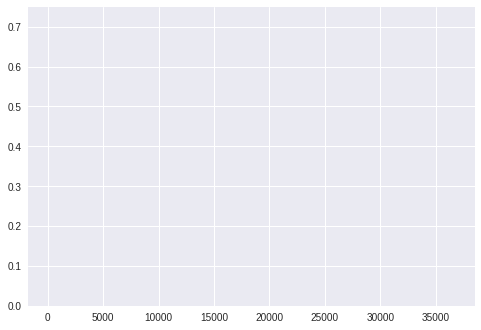

In [0]:
from baselines.common import plot_util as pu
results = pu.load_results(log_dir)

import matplotlib.pyplot as plt
import numpy as np
r = results[0]
plt.ylim(0, .75)
# plt.plot(np.cumsum(r.monitor.l), r.monitor.r)
plt.plot(np.cumsum(r.monitor.l), pu.smooth(r.monitor.r, radius=100))

# Enjoy model

In [0]:
import numpy as np 

observation = env.reset()
env.render()
baseline = Baseline(env)

{'S': 0, 'A': 1000, 'B': 1000, 'C': 0, 'D': 1000, 'E': 1000, 'F': 0, 'G': 1000, 'H': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 0, 'O': 1000}


In [0]:
state = np.zeros((1, 2*128))
dones = np.zeros((1))

BeraterEnv.showStep = True
BeraterEnv.showDone = False

for t in range(1000):
    actions, _, state, _ = model.step(observation, S=state, M=dones)
    observation, reward, done, info = env.step(actions[0])
    if done:
        print("Episode finished after {} timesteps, reward={}".format(t+1, env.totalReward))
        break
env.close()

Episode:    0   Step:    1  S --3-> S R=-0.17 totalR=-0.17 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    2  S --3-> S R=-0.17 totalR=-0.33 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    3  S --3-> S R=-0.17 totalR=-0.50 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    4  S --3-> S R=-0.17 totalR=-0.67 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    5  S --3-> S R=-0.17 totalR=-0.83 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    6  S --3-> S R=-0.17 totalR=-1.00 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    7  S --3-> S R=-0.17 totalR=-1.17 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    8  S --3-> S R=-0.17 totalR=-1.33 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:    9  S --3-> S R=-0.17 totalR=-1.50 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:   10  S --3-> S R=-0.17 totalR=-1.67 cost=1000 customerR=   0 optimum=6000
Episode:    0   Step:   11  S 

In [0]:
%time baseline.find_optimum()

Scaled reward: 0.7583333333333333
Perfect path ['S', 'B', 'C', 'M', 'N', 'O', 'G', 'F', 'D', 'F', 'E', 'A', 'B', 'S']
CPU times: user 78.5 ms, sys: 542 µs, total: 79 ms
Wall time: 80.4 ms


{'cost': 1450,
 'path': ['S',
  'B',
  'C',
  'M',
  'N',
  'O',
  'G',
  'F',
  'D',
  'F',
  'E',
  'A',
  'B',
  'S'],
 'position': 'S',
 'reward': 6000,
 'rewards': {'A': 0,
  'B': 0,
  'C': 0,
  'D': 0,
  'E': 0,
  'F': 0,
  'G': 0,
  'H': 0,
  'K': 0,
  'L': 0,
  'M': 0,
  'N': 0,
  'O': 0,
  'S': 0},
 'scaled_reward': 0.7583333333333333}

## Evaluation

In [0]:
baseline = Baseline(env)
perfect_score_mean, perfect_score_std, test_score_mean, test_score_std = baseline.score(model, sample_runs=100)

In [0]:
# perfect scores
perfect_score_mean, perfect_score_std

(0.7325833333333331, 0.034117749535005)

In [0]:
# test scores for our model
test_score_mean, test_score_std

(-166.6666666666659, 2.842170943040401e-14)